In [31]:
import numpy as np

class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=15):
        self.eta = eta
        self.n_iter = n_iter
        self.w = None
        self.errors = []
        
    def fit(self, X, y, scale_x=False):
        """
        X - [n_samples, n_features]
        y - [n_samples]
        """
        self.w = np.zeros(1 + X.shape[1])
        if scale_x:
            X = self.feature_scaling(X)
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w[1:] += update * xi
                self.w[0] += update
                errors += int(update != 0.0)
            self.errors.append(errors)
        
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w[1:]) + self.w[0]
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0, 1, -1)
    
    def feature_scaling(self, X):
        X_std = np.copy(X)
        for j in range(X.shape[1]):
            X_std[:, j] = (X[:, j] - X[:, j].mean()) / X[:, j].std()
        return X_std

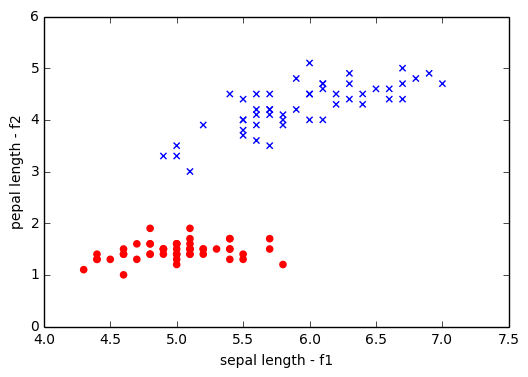

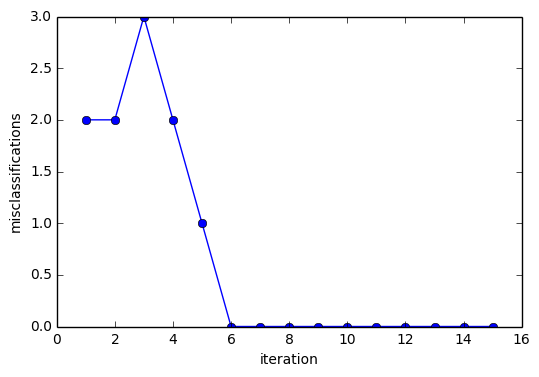

In [32]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1) # labels for iris-setosa and iris-versicolor

X = df.iloc[0:100, [0, 2]].values # we are taking just 2 features

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length - f1')
plt.ylabel('pepal length - f2')
plt.show()

ppn = Perceptron(eta=0.1)
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors) + 1), ppn.errors, marker='o')
plt.xlabel('iteration')
plt.ylabel('misclassifications')

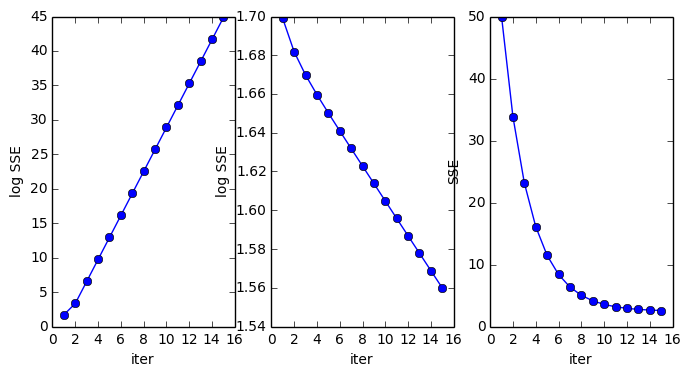

In [33]:
class AdalineGD(Perceptron):
    
    def fit(self, X, y, scale_x=False):
        """
        X - [n_samples, n_features]
        y - [n_samples]
        """
        self.w = np.zeros(1 + X.shape[1])
        self.cost = []
        
        if scale_x:
            X = self.feature_scaling(X)

        for _ in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w[1:] += self.eta * X.T.dot(errors)
            self.w[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost.append(cost)
        
        return self

    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
ada1 = AdalineGD(eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost) + 1), np.log10(ada1.cost), marker='o')
ax[0].set_xlabel('iter')
ax[0].set_ylabel('log SSE')

ada2 = AdalineGD(eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost) + 1), np.log10(ada2.cost), marker='o')
ax[1].set_xlabel('iter')
ax[1].set_ylabel('log SSE')

ada_features_scale = AdalineGD().fit(X, y, scale_x=True)
ax[2].plot(range(1, len(ada_features_scale.cost)+1), ada_features_scale.cost, marker='o')
ax[2].set_xlabel('iter')
ax[2].set_ylabel('SSE')


ValueError: x and y must have same first dimension

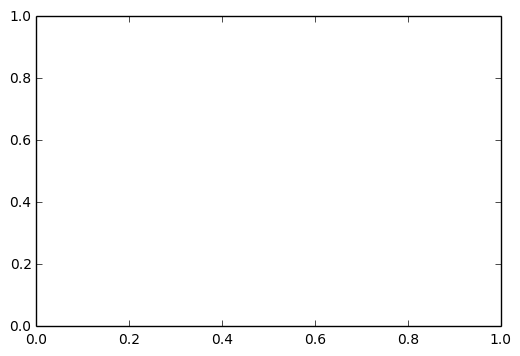

In [41]:
from numpy.random import seed

class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=15, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        self._w_init = False
        
    def fit(self, X, y):
        self._init_w(X.shape[1])
        self.cost = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_w(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost.append(avg_cost)
        
        return self
    
    def partial_fit(self, X, y):
        if not self._w_init:
            self._init_w(X.shape[1])
        
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_w(xi, target)
        else:
            self._update_w(X, y)
        
        return self
    
    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _init_w(self, m):
        self.w = np.zeros(1+m)
        self._w_init = True
        
    def _update_w(self, xi, target):
        output = self.net_input(xi)
        error = (target - output)
        self.w[1:] += self.eta * xi.dot(error)
        self.w[0] += self.eta * error
        cost = error**2 / 2.0
        return cost

    def net_input(self, X):
        return np.dot(X, self.w[1:]) + self.w[0]
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0, 1, -1)
        

ada_sgd = AdalineSGD(eta=0.01).fit(X, y)
plt.plot(range(1, len(ada_sgd.cost) + 1), ada_sgd.cost, marker='o')
plt.xlabel('iteration')
plt.ylabel('error')